In [45]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import util
import numpy as np
import heapq
from sklearn.decomposition import PCA

In [46]:
model = SentenceTransformer('all-MiniLM-L6-v2')

df = pd.read_csv('test.csv', header = 0, sep = ",")
answers = df.iloc[:,1]
student_id = df.iloc[:,0]
sentences = []
for answer in answers:
    sentences.append(answer)
bert_embeddings = model.encode(answers)
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=2)
clustering_model.fit(bert_embeddings)
bert_label = clustering_model.labels_

df_clusters = pd.DataFrame({
    "id": student_id,
    "text": answers,
    "agg_bert_row": bert_label,
})


[[-0.22541061 -0.19388039]
 [ 0.54451871 -0.01331563]
 [ 0.00199625  0.10411049]
 [-0.40344722 -0.26686162]
 [ 0.05063044  0.04181397]
 [-0.04127735  0.14772102]
 [ 0.12269133  0.05520778]
 [-0.4693852  -0.25249487]
 [ 0.00786551  0.78520157]
 [-0.4693852  -0.25249487]
 [ 0.03157322  0.02006026]
 [ 0.00786551  0.78520157]
 [-0.07737083 -0.04968011]
 [-0.09201482 -0.08498987]
 [ 0.04074169 -0.1149681 ]
 [ 0.839315   -0.22592361]
 [-0.44571633 -0.25263452]
 [ 0.00351332 -0.18413335]
 [-0.13659416 -0.11519546]
 [ 0.26052043 -0.28692619]
 [ 0.07031962  0.21232555]
 [ 0.02695564  0.09783438]
 [ 0.09547349  0.21376393]
 [ 0.00786551  0.78520157]
 [-0.24803363 -0.04286796]
 [ 0.839315   -0.22592361]
 [-0.41329315 -0.23654337]
 [ 0.839315   -0.22592361]
 [ 0.12269133  0.05520778]
 [ 0.00786551  0.78520157]
 [-0.06911566 -0.04055042]
 [ 0.839315   -0.22592361]
 [-0.47427291 -0.17574887]
 [-0.14621416  0.03701778]
 [-0.21914512 -0.1533638 ]
 [ 0.839315   -0.22592361]
 [ 0.1010873   0.17673177]
 

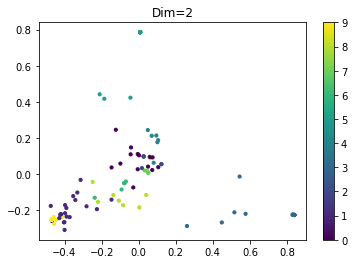

,id,text,agg_bert_row,x_position,y_position
0,1,Radical ideas,1,-0.225411,-0.193880
1,2,No judgement,3,0.544519,-0.013316
2,3,speed dating,0,0.001996,0.104110
3,4,Make multiple ideas,1,-0.403447,-0.266862
4,5,Yes and,0,0.050630,0.041814
...,...,...,...,...,...
105,106,Coming up with lots of ideas,1,-0.423064,-0.223820
106,107,Cluster and select,0,0.075199,0.092725
107,108,conversations take place on at a time,7,0.044080,0.019443
108,109,Be visual,5,0.007866,0.785202


In [70]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 

# 初始化 PCA 降维模型
pca = PCA(n_components=2)
embedding_list = []
for i in bert_embeddings:
    embedding_list.append(i)
# 训练模型
compress_embedding = pca.fit_transform(embedding_list)
print(compress_embedding)
 
# 可视化
plt.scatter(compress_embedding[:, 0], compress_embedding[:, 1], s=10, c=bert_label)
plt.title("Dim=2")
plt.colorbar()
plt.show()

vector_2 = pd.DataFrame(compress_embedding)
df_clusters["x_position"] = vector_2.iloc[:,0]
df_clusters["y_position"] = vector_2.iloc[:,1]
df_clusters


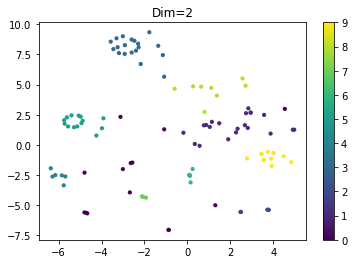

In [77]:
from sklearn.manifold import TSNE 

X_embedded = TSNE(n_components=2).fit_transform(embedding_list)
vector_2 = pd.DataFrame(compress_embedding)
df_clusters["x_position"] = vector_2.iloc[:,0]
df_clusters["y_position"] = vector_2.iloc[:,1]
df_clusters

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, c=bert_label)
plt.title("Dim=2")
plt.colorbar()
plt.show()

In [79]:
length = []
for i in range(0,len(student_id)):
    answer_length = len(answers[i])
    length.append(answer_length)
df_clusters["answer_length"] = length
    

计算每一类类中心的向量

In [42]:
clusters = {}
groups = {}
for i in range(0,len(student_id)):
    i_cluster = bert_label[i]
    if i_cluster not in clusters:
        groups[i_cluster] = 1
        clusters[i_cluster] = bert_embeddings[i]
    else:
        groups[i_cluster] +=1
        clusters[i_cluster] = clusters[i_cluster] + bert_embeddings[i]
# center of the cluster       
for key in clusters:
    clusters[key] = clusters[key]/groups[key]


找到每一个组的离群点（是否加入老师的input？）

In [43]:
distant_point = {}
distant_point_id = {}
for i in range(0, len(student_id)):
    i_cluster = bert_label[i]
    cos_sim = util.cos_sim(bert_embeddings[i], clusters[i_cluster])
    if i_cluster not in distant_point:
        distant_point[i_cluster] = cos_sim
        distant_point_id[i_cluster] = i
    else:
        if(cos_sim < distant_point[i_cluster]):
            distant_point[i_cluster] = cos_sim
            distant_point_id[i_cluster] = i
with open("data/distant_point.txt", "w") as f:
    f.write(distant_point_id)
print(distant_point_id)

{1: 0, 3: 1, 0: 4, 2: 76, 9: 16, 5: 61, 7: 10, 6: 13, 8: 67, 4: 74}


老师可以在这里选择调整距离

In [44]:
influenced_points = {}
for key in distant_point_id:
    id = distant_point_id[key]
    if(distant_point[key]<0.8):
        key_vector = bert_embeddings[id]
        key_similarity_list = []
        for i in range(0,len(student_id)):
            cos_sim = util.cos_sim(bert_embeddings[id], bert_embeddings[i])
            key_similarity_list.append(cos_sim)
        influenced_points[key] = key_similarity_list

most_similar = {}
for key in influenced_points:
    max_index = []
    max_number = heapq.nlargest(6,influenced_points[key]) 
    for t in max_number:
        index = influenced_points[key].index(t)
        max_index.append(index)
        influenced_points[key][index] = 0
    most_similar[key] = max_index
print(most_similar)
most_similar_answer = {}
for key in most_similar:
    similar_answers = []
    for i in most_similar[key]:
        similar_answer = answers[i]
        similar_answers.append(similar_answer)
    most_similar_answer[key] = similar_answers
print(most_similar_answer)

{1: [0, 68, 95, 41, 104, 64], 3: [1, 15, 25, 27, 31, 35], 0: [4, 16, 21, 38, 98, 10], 5: [61, 48, 8, 11, 23, 29], 8: [67, 24, 1, 65, 14, 43], 4: [74, 36, 20, 22, 99, 80]}
{1: ['Radical ideas ', 'build off of other ideas', 'Building on others ideas', 'Diversity of ideas', "Build on other's ideas. ", 'Come up with a large number of ideas'], 3: ['No judgement', 'Defer judgement', 'Defer Judgement', 'Defer judgement', 'defer judgement', 'defer judgement '], 0: ['Yes and', 'include all wild ideas too', 'Go for quantity ', 'Go for quantity', 'Go for quantity', 'one conversation at a time'], 5: ['be visual; this is to say that human centered design should focus primarily on visual elements', 'Being visual helps other understand your ideas or suggestions very quickly ', 'Be visual', 'Be visual ', 'be visual', 'Be visual'], 8: ['No hate', 'Dont hate, just come up with ideas dont worry about quality of them yet', 'No judgement', 'No such thing as a bad idea', 'dont judge the idea', 'Defer judgem